In [3]:
import yfinance
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.titlesize'] = 14 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16

In [6]:
eth = pd.read_csv('data/eth-usd.csv', header=0, usecols=['timestamp','close'], parse_dates=['timestamp'], index_col=['timestamp'])


eth = eth.rename(columns={'close': 'price'})
eth.head()

,price
timestamp,
2015-08-07,3.00
2015-08-08,1.20
2015-08-09,1.20
2015-08-10,1.20
2015-08-11,0.99


In [7]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1764 entries, 2015-08-07 to 2020-06-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1764 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


In [8]:
eth.describe()

,price
count,1764.000000
mean,201.292612
std,230.496516
min,0.420000
25%,11.750000
50%,158.655000
75%,269.312500
max,1398.990000


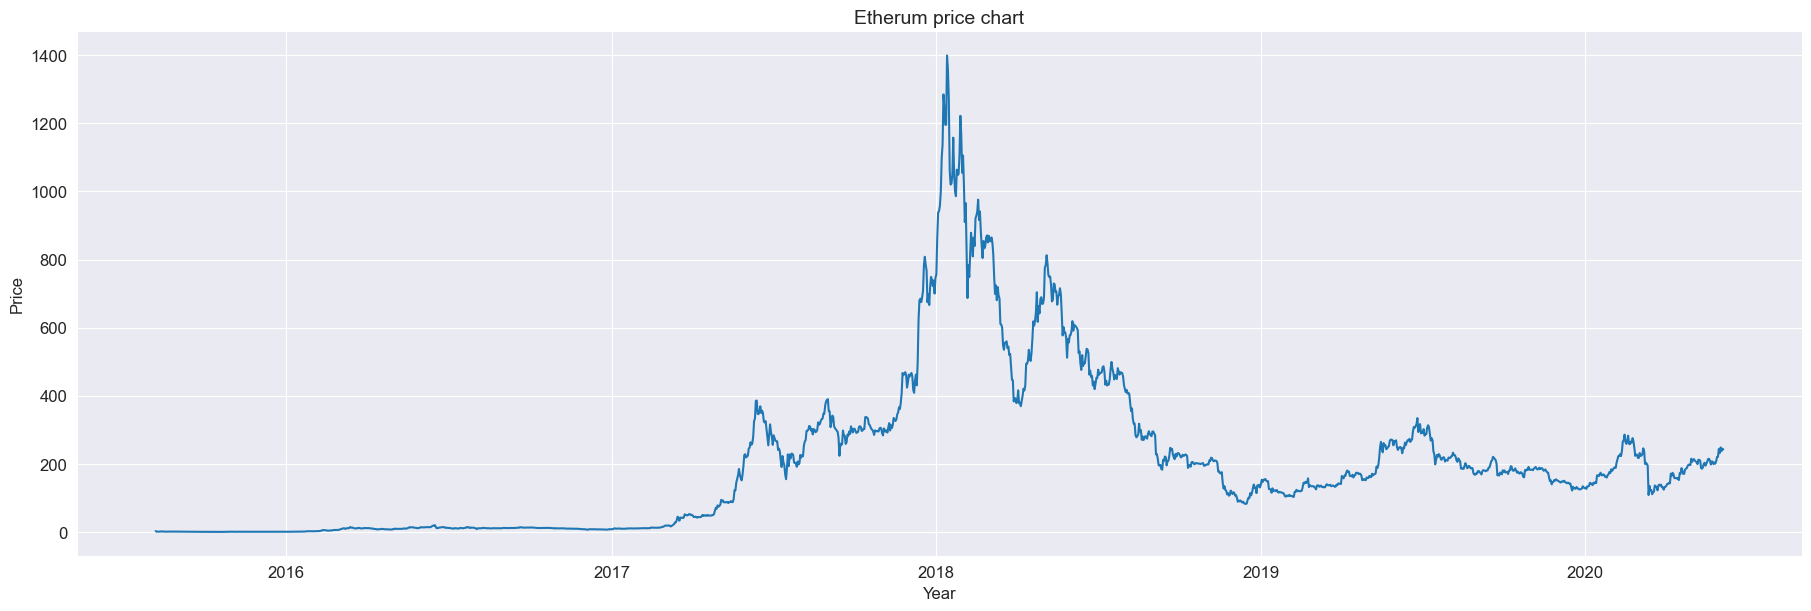

In [9]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Etherum price chart')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(eth)
ax.set_xlabel('Year')
ax.set_ylabel('Price') 
plt.show()

In [10]:
rolling_mean = eth.rolling(window = 12).mean()
rolling_std = eth.rolling(window = 12).std()
print(rolling_mean,rolling_std)

                 price
timestamp             
2015-08-07         NaN
2015-08-08         NaN
2015-08-09         NaN
2015-08-10         NaN
2015-08-11         NaN
...                ...
2020-05-31  212.608333
2020-06-01  215.823333
2020-06-02  219.090000
2020-06-03  222.199167
2020-06-04  225.199167

[1764 rows x 1 columns]                 price
timestamp            
2015-08-07        NaN
2015-08-08        NaN
2015-08-09        NaN
2015-08-10        NaN
2015-08-11        NaN
...               ...
2020-05-31  13.920120
2020-06-01  17.279939
2020-06-02  17.381381
2020-06-03  18.375568
2020-06-04  18.554726

[1764 rows x 1 columns]


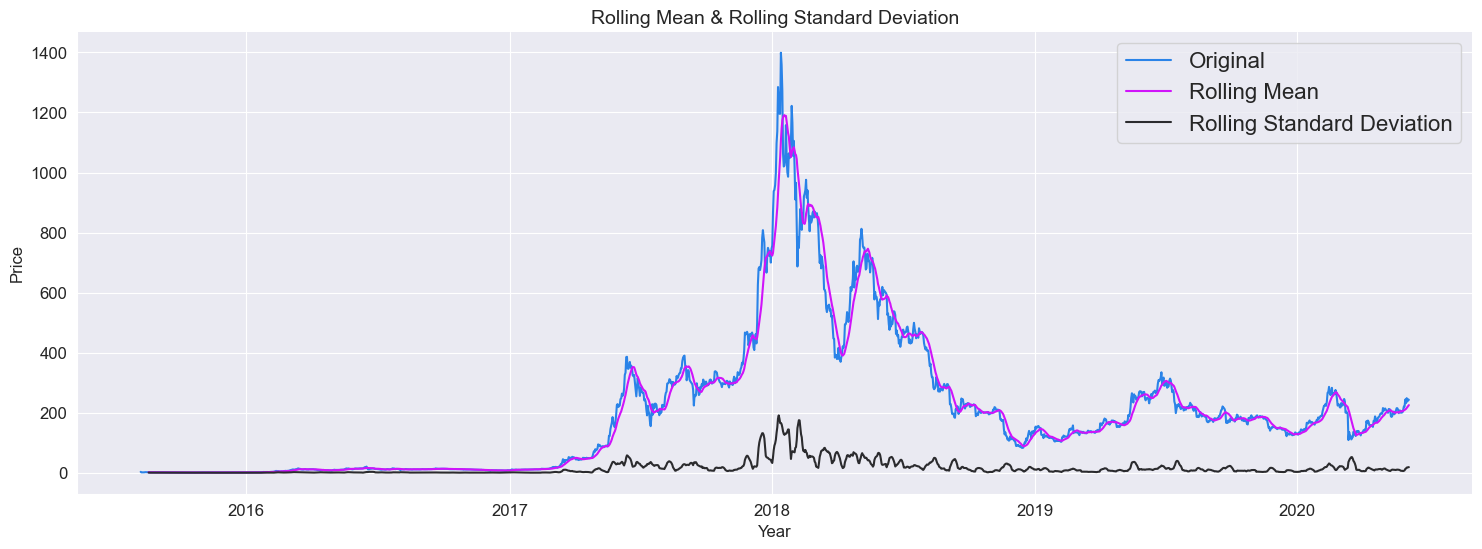

In [11]:
plt.plot(eth, color = '#2a83e8', label = 'Original')
plt.plot(rolling_mean, color = '#d014fa', label = 'Rolling Mean')
plt.plot(rolling_std, color = '#2b2b2e', label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.xlabel('Year')
plt.ylabel('Price') 
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [12]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
result = adfuller(btc['price'], autolag='AIC')
result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    result_output['Critical Value (%s)'%key] = value    
print(result_output)

Results of Dickey Fuller Test:
Test Statistic                   -2.348010
p-value                           0.156951
#Lags Used                       25.000000
Number of Observations Used    1738.000000
Critical Value (1%)              -3.434118
Critical Value (5%)              -2.863204
Critical Value (10%)             -2.567656
dtype: float64


The ADF statistics are far from critical and the p-value is greater than the threshold (0,05). Therefore, we can conclude that the time series is not stationary.



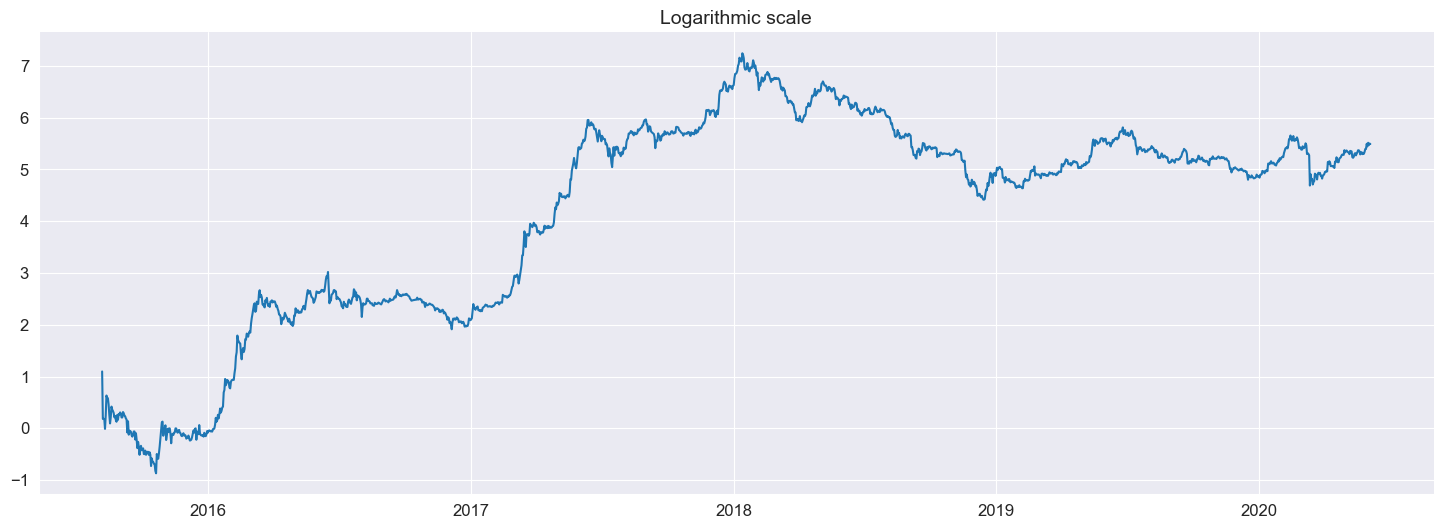

In [13]:
eth_log = np.log(eth)

plt.title('Logarithmic scale')
plt.plot(eth_log)
plt.show()

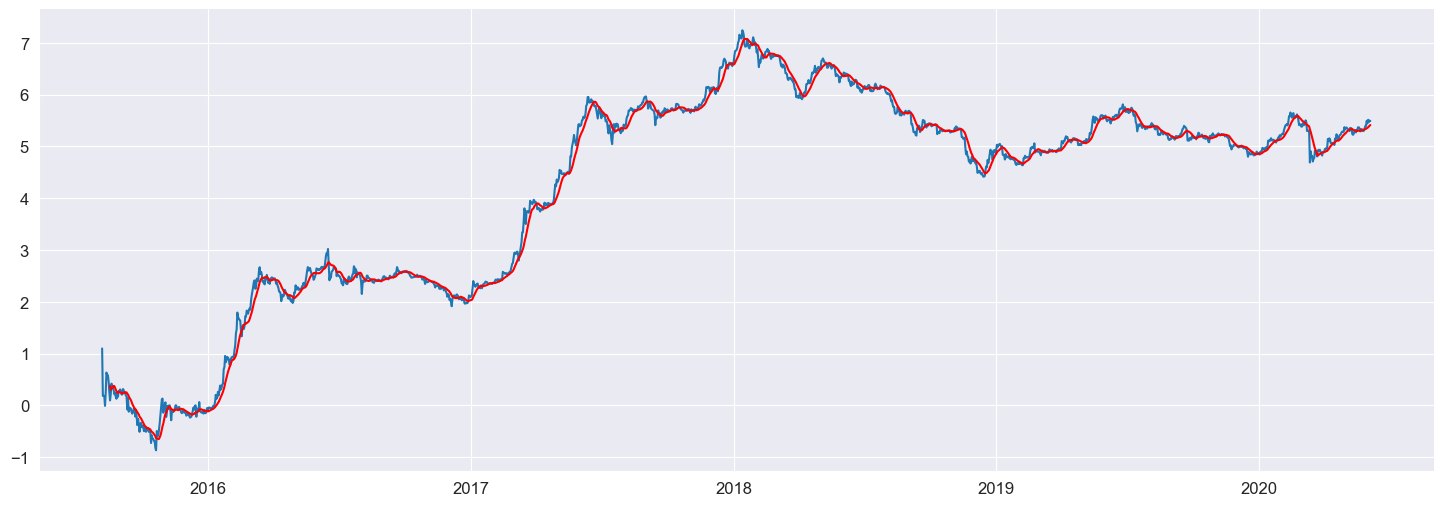

In [14]:
#The below transformation is required to make series stationary
movingAverage = eth_log.rolling(window=12).mean()
movingSTD = eth_log.rolling(window=12).std()
plt.plot(eth_log)
plt.plot(movingAverage, color='red')
plt.show()

We will create a function that will run two tests that will determine whether a given time series is stationary.

In [15]:
ethLogMinusMovingAverage = eth_log - movingAverage
ethLogMinusMovingAverage.head(12)

#Remove NAN values
ethLogMinusMovingAverage.dropna(inplace=True)
ethLogMinusMovingAverage.head(10)

,price
timestamp,
2015-08-18,-0.280312
2015-08-19,-0.086885
2015-08-20,0.098220
2015-08-21,0.025094
2015-08-22,-0.013141
2015-08-23,-0.075355
2015-08-24,-0.158663
2015-08-25,-0.099512
2015-08-26,-0.138844


In [16]:
def test_stationarity(timeseries):
    
    # rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='#2a83e8', label='Original')
    mean = plt.plot(movingAverage, color='#d014fa', label='Rolling Mean')
    std = plt.plot(movingSTD, color='#2b2b2e', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('\nResults of Dickey Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        result_output['Critical Value (%s)'%key] = value
    print(result_output)

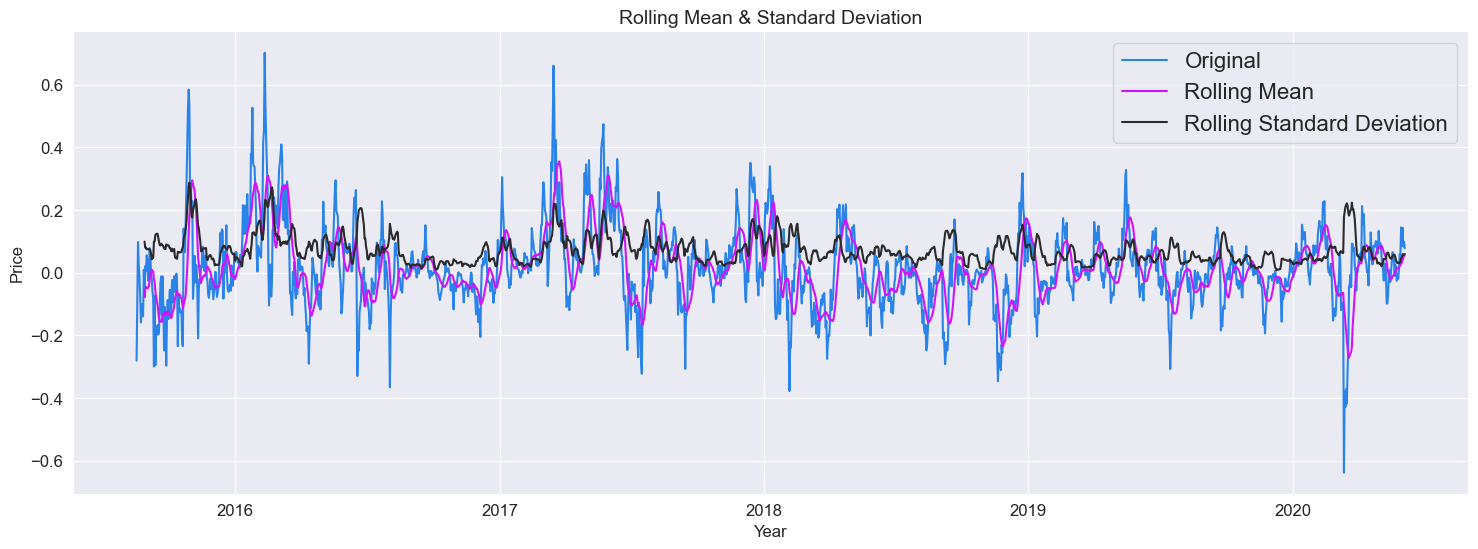


Results of Dickey Fuller Test:
Test Statistic                -7.445078e+00
p-value                        5.867293e-11
#Lags Used                     1.100000e+01
Number of Observations Used    1.741000e+03
Critical Value (1%)           -3.434112e+00
Critical Value (5%)           -2.863202e+00
Critical Value (10%)          -2.567655e+00
dtype: float64


In [17]:
test_stationarity(ethLogMinusMovingAverage)

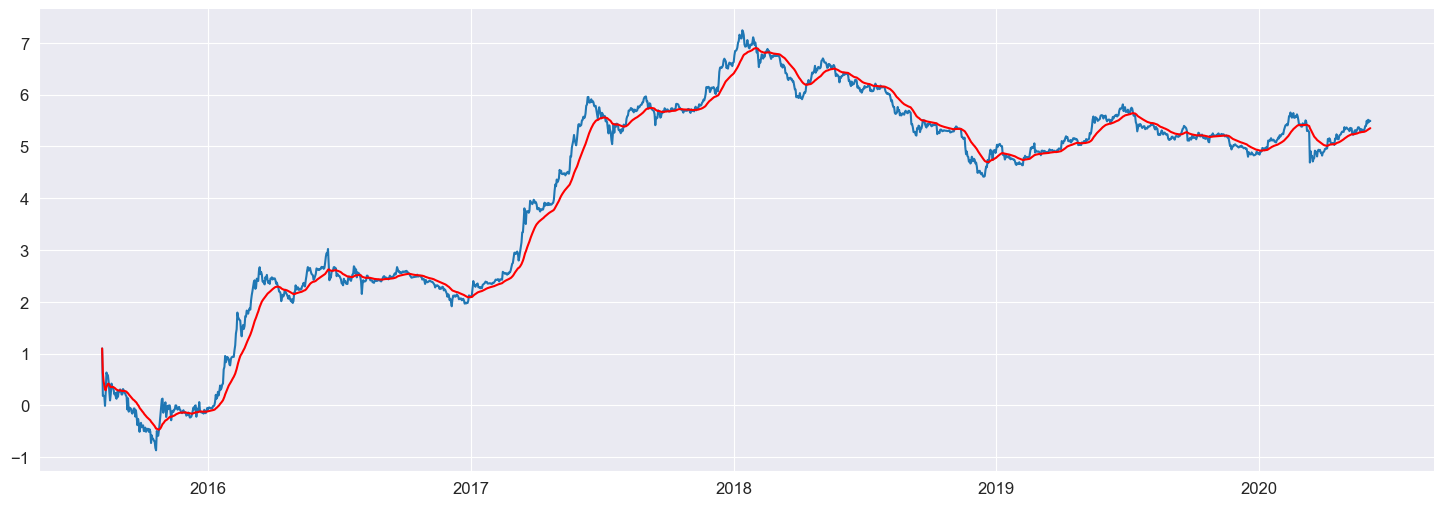

In [18]:
exponentialDecayWeightedAverage = eth_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(eth_log)
plt.plot(exponentialDecayWeightedAverage, color='red')
plt.show()

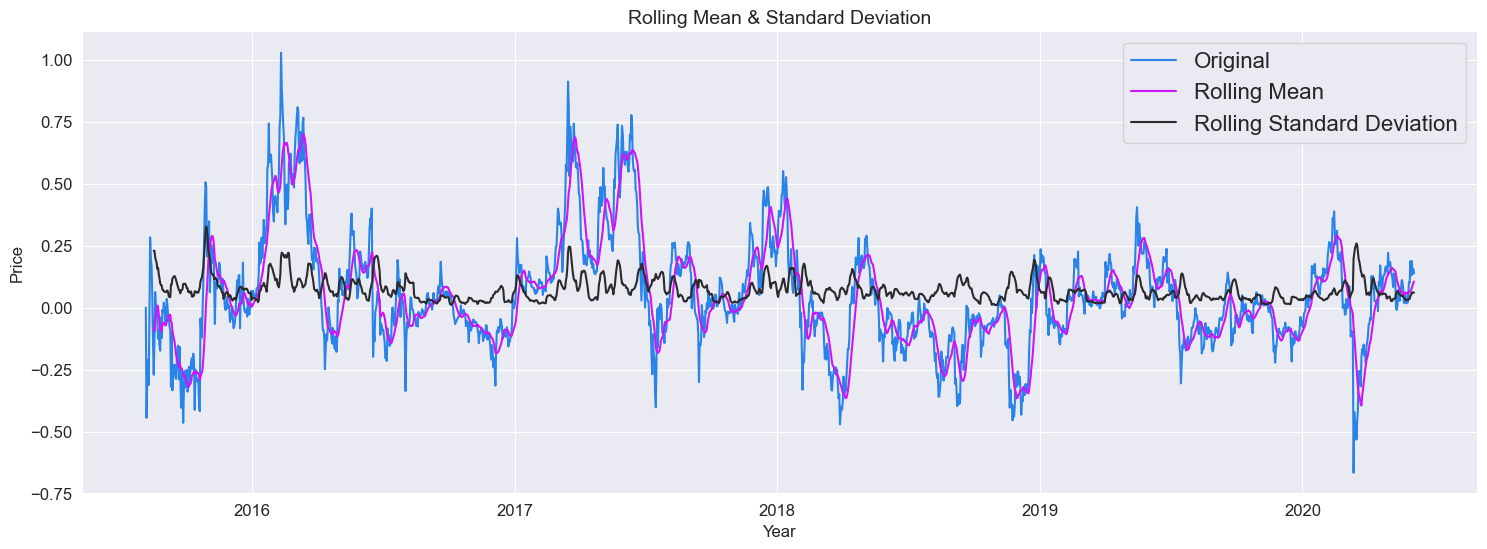


Results of Dickey Fuller Test:
Test Statistic                   -5.294228
p-value                           0.000006
#Lags Used                       19.000000
Number of Observations Used    1744.000000
Critical Value (1%)              -3.434105
Critical Value (5%)              -2.863199
Critical Value (10%)             -2.567653
dtype: float64


In [19]:
ethLogMinusExponentialMovingAverage = eth_log - exponentialDecayWeightedAverage
test_stationarity(ethLogMinusExponentialMovingAverage)

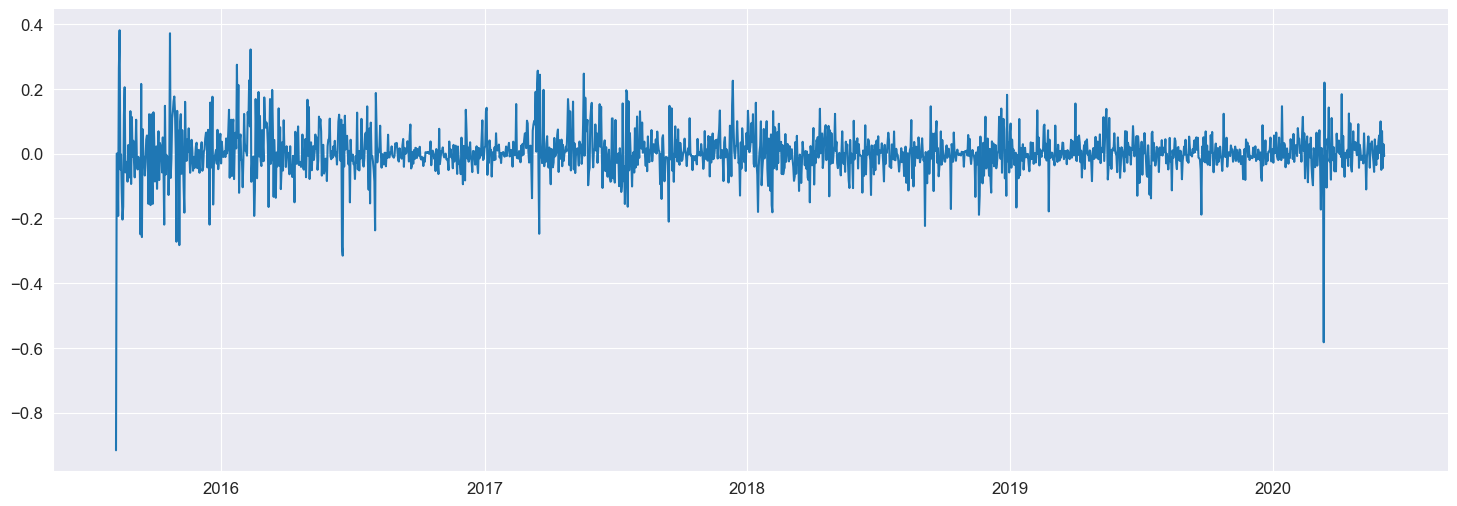

In [20]:
ethLogDiffShifting = eth_log - eth_log.shift()
plt.plot(ethLogDiffShifting)
plt.show()

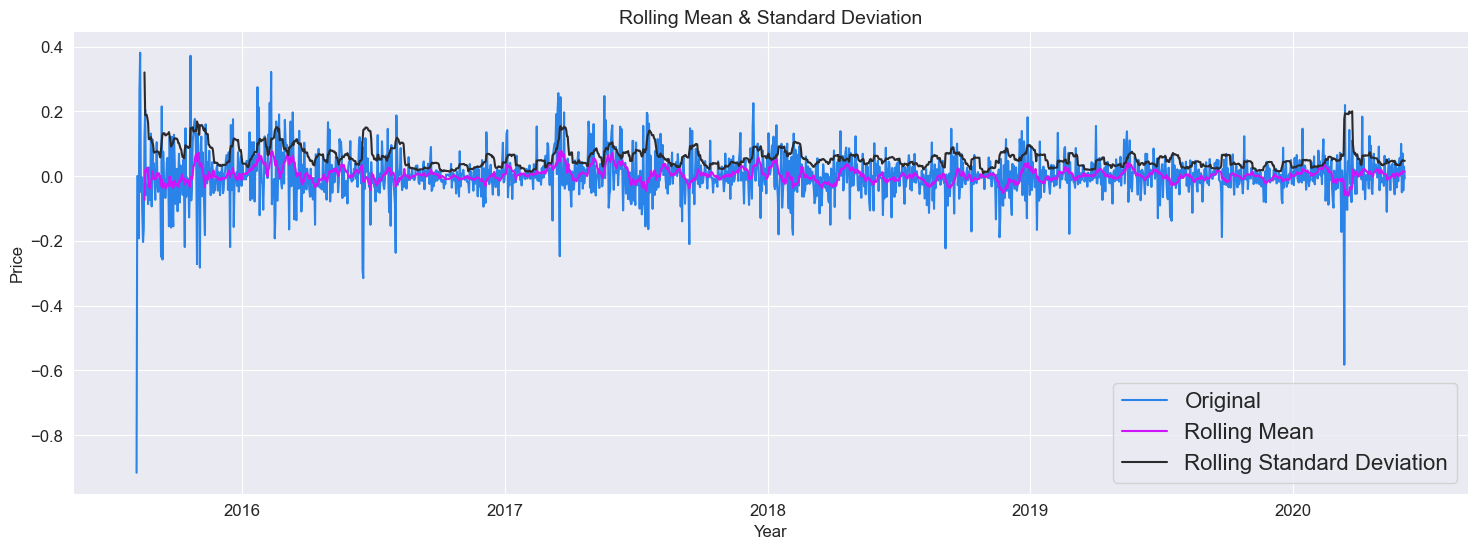


Results of Dickey Fuller Test:
Test Statistic                -7.396978e+00
p-value                        7.731998e-11
#Lags Used                     1.800000e+01
Number of Observations Used    1.744000e+03
Critical Value (1%)           -3.434105e+00
Critical Value (5%)           -2.863199e+00
Critical Value (10%)          -2.567653e+00
dtype: float64


In [21]:
ethLogDiffShifting.dropna(inplace=True)
test_stationarity(ethLogDiffShifting)

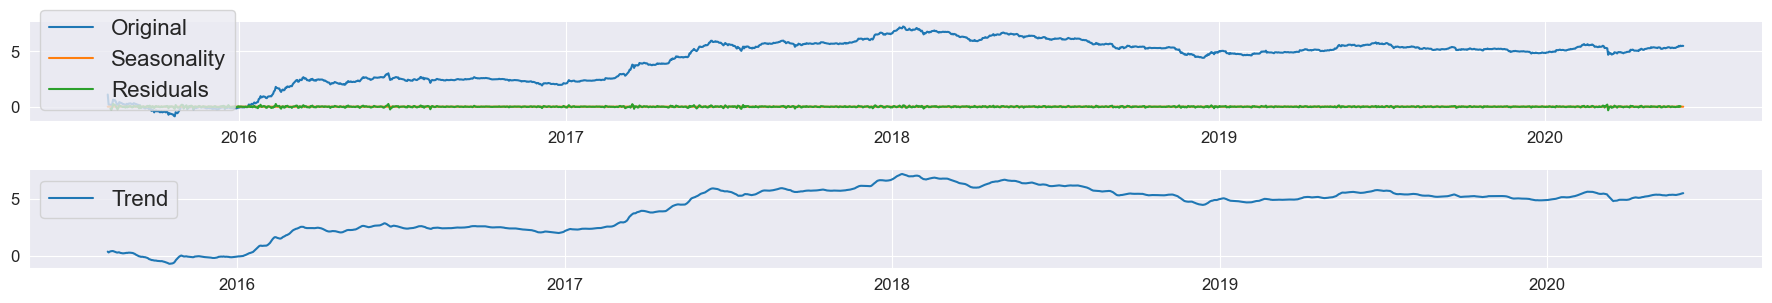

In [25]:
decomposition = seasonal_decompose(eth_log) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(eth_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

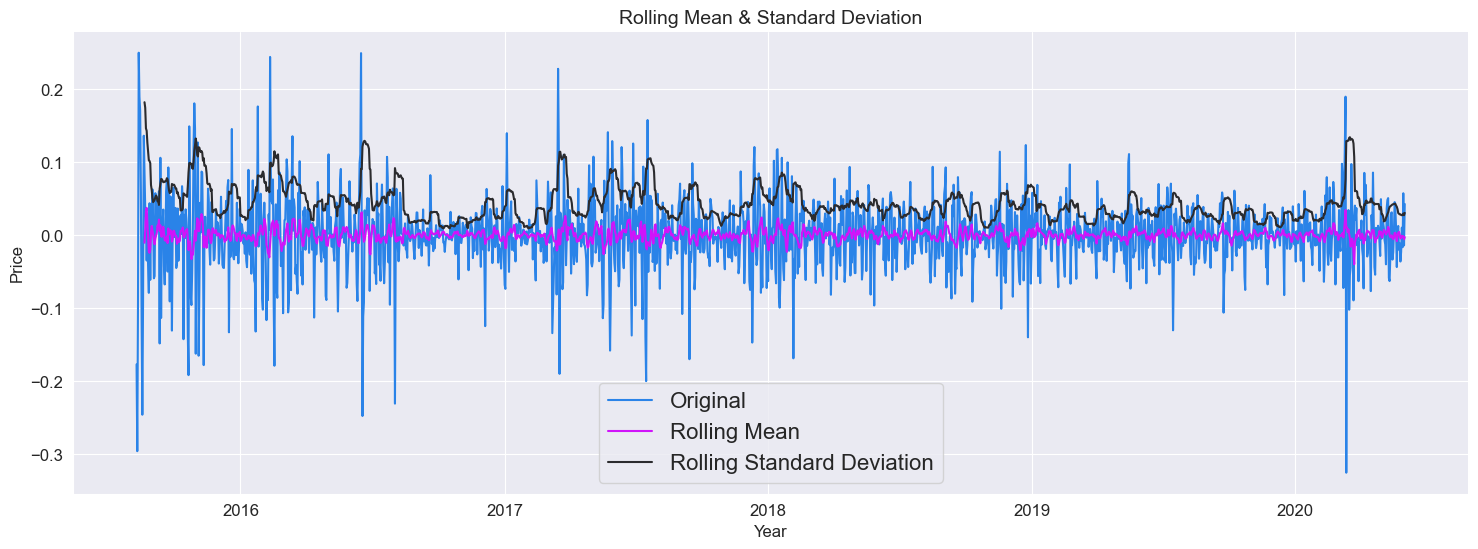


Results of Dickey Fuller Test:
Test Statistic                -1.698435e+01
p-value                        8.964182e-30
#Lags Used                     1.700000e+01
Number of Observations Used    1.740000e+03
Critical Value (1%)           -3.434114e+00
Critical Value (5%)           -2.863202e+00
Critical Value (10%)          -2.567655e+00
dtype: float64


In [26]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

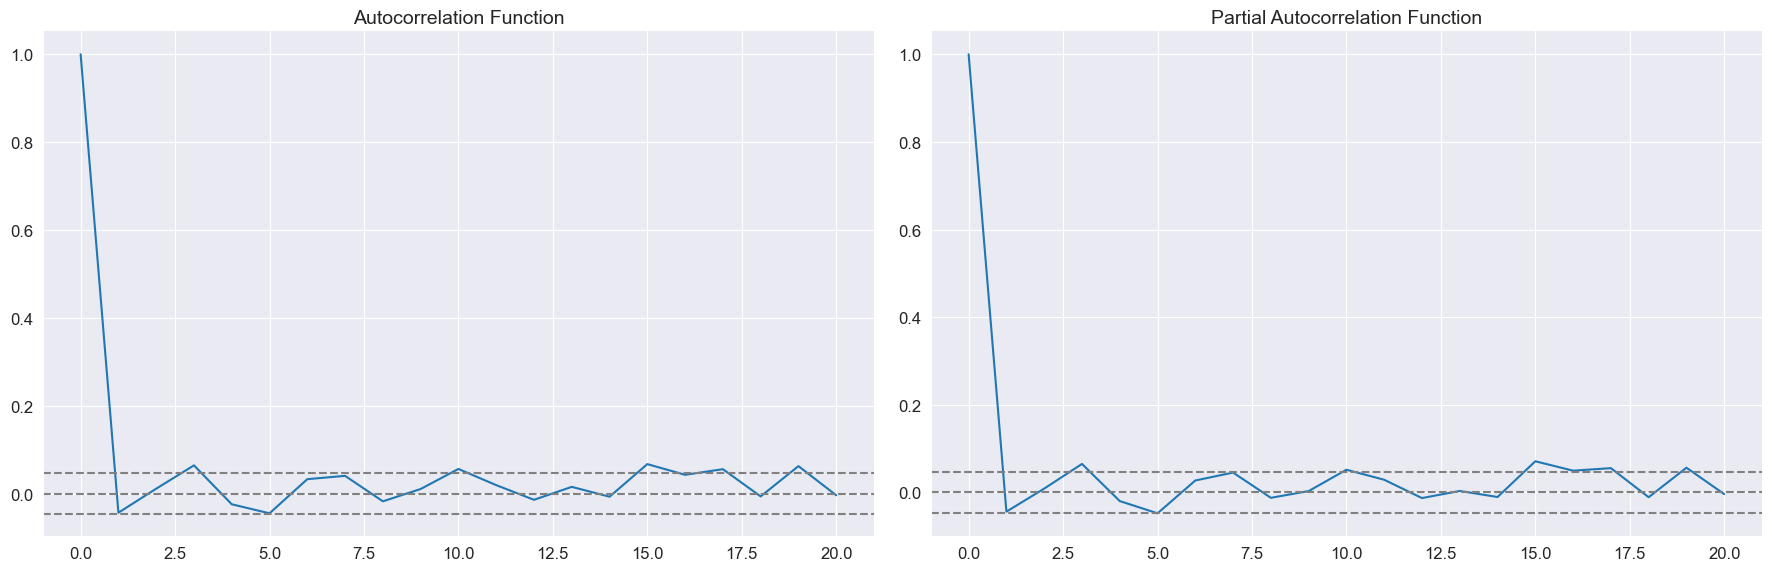

In [28]:
#ACF & PACF plots
lag_acf = acf(ethLogDiffShifting, nlags=20)

lag_pacf = pacf(ethLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ethLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ethLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ethLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ethLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

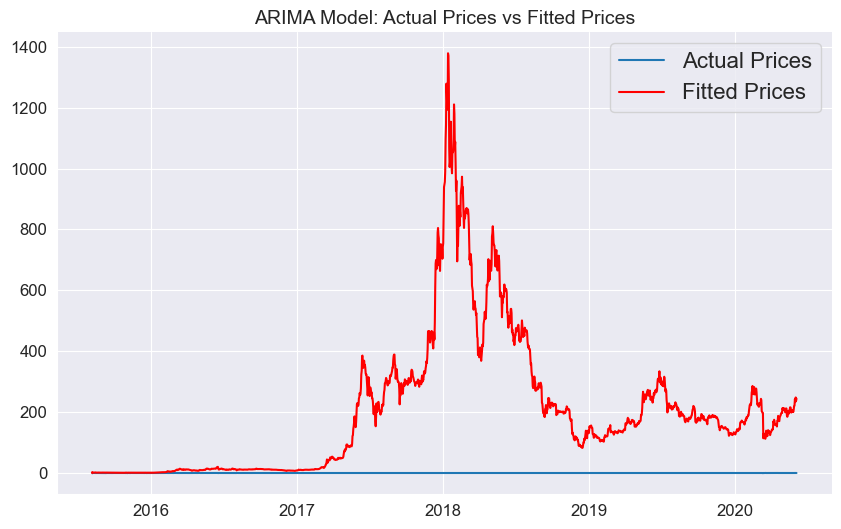

Residual Sum of Squares (RSS): nan


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Fit the ARIMA model
model = ARIMA(eth_log, order=(2, 1, 2))

results_AR = model.fit()

# Calculate the fitted values
fitted_values = results_AR.fittedvalues

# Convert the fitted values back to original scale (inverse log transform)
predicted_prices = np.exp(fitted_values)

# Plot the actual data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(ethLogDiffShifting['price'], label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Fitted Prices')

plt.title('ARIMA Model: Actual Prices vs Fitted Prices')
plt.legend()
plt.show()

# Calculate the Residual Sum of Squares (RSS)
rss = sum((results_AR.fittedvalues - ethLogDiffShifting['price'])**2)
print(f'Residual Sum of Squares (RSS): {rss:.4f}')

with open('eth_arima_model.pkl', 'wb') as f:
    pickle.dump(results_AR, f)

In [45]:
# Debugging step to identify the source of the issue
print("Length of actual_prices:", len(actual_prices))
print("Length of predicted_prices:", len(predicted_prices))

# Verify the content of actual_prices and predicted_prices
print("Actual Prices:", actual_prices)
print("Predicted Prices:", predicted_prices)


Length of actual_prices: 1763
Length of predicted_prices: 1764
Actual Prices: timestamp
2015-08-08   -0.916291
2015-08-09    0.000000
2015-08-10    0.000000
2015-08-11   -0.192372
2015-08-12    0.263141
                ...   
2020-05-31   -0.050236
2020-06-01    0.069539
2020-06-02   -0.044863
2020-06-03    0.029001
2020-06-04   -0.007512
Name: price, Length: 1763, dtype: float64
Predicted Prices: timestamp
2015-08-07      1.000000
2015-08-08      3.000000
2015-08-09      1.276590
2015-08-10      1.177075
2015-08-11      1.143198
                 ...    
2020-05-31    242.295182
2020-06-01    232.930270
2020-06-02    248.040484
2020-06-03    237.811616
2020-06-04    244.053489
Length: 1764, dtype: float64


In [36]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

timestamp
2015-08-07    0.000000
2015-08-08    1.098612
2015-08-09    0.244193
2015-08-10    0.163032
2015-08-11    0.133830
dtype: float64


In [37]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

timestamp
2015-08-07       0.000000
2015-08-08       1.098612
2015-08-09       1.342805
2015-08-10       1.505837
2015-08-11       1.639667
                 ...     
2020-05-31    7362.981623
2020-06-01    7368.432362
2020-06-02    7373.945954
2020-06-03    7379.417433
2020-06-04    7384.914820
Length: 1764, dtype: float64


In [38]:
predictions_ARIMA_log = pd.Series(eth_log['price'].iloc[0], index=eth_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2015-08-07    1.098612
2015-08-08    2.197225
2015-08-09    2.441417
2015-08-10    2.604449
2015-08-11    2.738279
dtype: float64

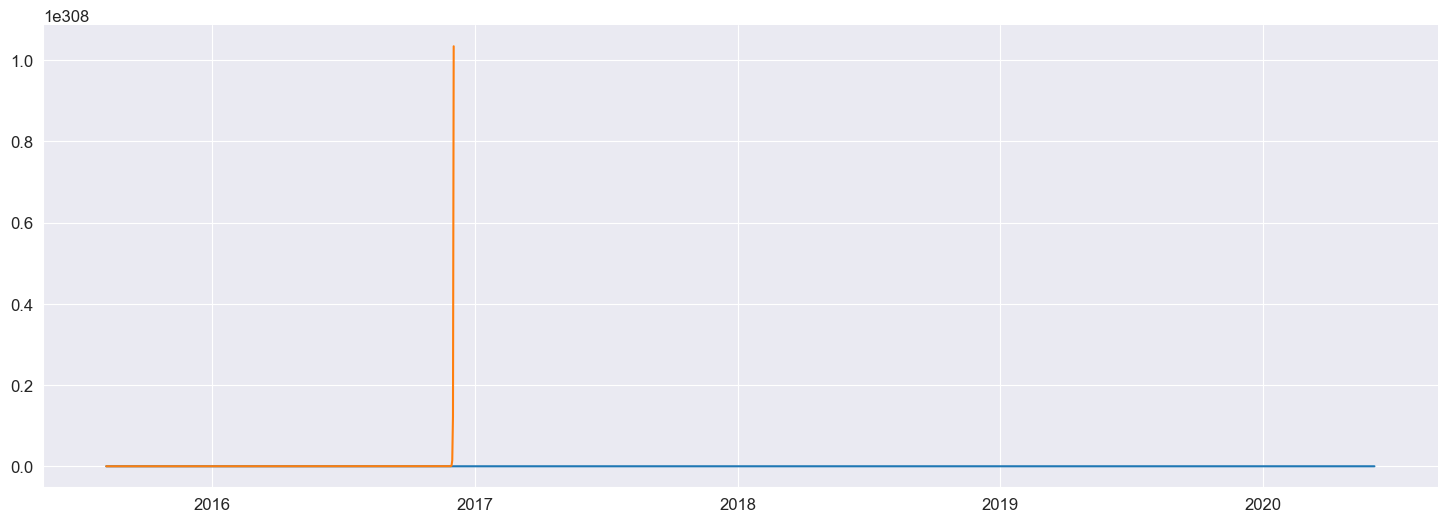

In [39]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(eth)
plt.plot(predictions_ARIMA)
plt.show()

In [53]:
eth_log

,price
timestamp,
2015-08-07,1.098612
2015-08-08,0.182322
2015-08-09,0.182322
2015-08-10,0.182322
2015-08-11,-0.010050
...,...
2020-05-31,5.445702
2020-06-01,5.515242
2020-06-02,5.470378
